In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (10,4)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

In [2]:
def draw_plot(x, y, title='', xlabel='', ylabel=''):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.plot(x, y, linewidth=2)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=legend_fontsize)
    ax.set_xlabel(xlabel, fontsize=legend_fontsize)
    ax.set_ylabel(ylabel, fontsize=legend_fontsize)
    ax.legend(fontsize=legend_fontsize)
    plt.show()

# Продвинутое машинное обучение: ДЗ #1

### [Задание](https://docs.google.com/document/d/1snU4dXicuPmFz9XjTF8c7nSw0qGdJAgdJeZVrg-NakI/edit#)

### Часть I: О теореме Байеса

#### Убийство

Обозначим события: <br>
$guilty$ - подсудимый виновен <br>
$blood$ - у человека редкая группа крови

Рассмотрим рассуждение прокурора _"Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен - всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить"_

Прокурор рассмотрел вероятность $p(blood=1) = 0.01$ и посчитал, что $p(guilty=1) = 1 - p(blood=1) = 0.99$, что неверно.

Он должен был рассматривать вероятность $p(guilty=1|blood=1)$

По теореме Байеса:

$p(guilty=1|blood=1) = \frac{p(blood=1|guilty=1) * p(guilty=1)}{p(blood=1|guilty=1) * p(guilty=1) + p(blood=1|guilty=0) * p(guilty =0)}$

$p(blood=1|guilty=1) = 1$ (по условию)<br>
$p(blood=1|guilty=0)) = 0.01$ (вероятность редкой крови у человека, являющегося невиновным)

$p(guilty=1|blood=1) = \frac{p(guilty=1)}{p(guilty=1) + 0.01 * (1 - p(guilty=1)} = \frac{p(guilty=1)}{0.99 * p(guilty=1) + 0.01}$

$p(guilty=1)$ - это априорная вероятность виновности подсудимого. Если бы были какие-то еще улики, указывающие на виновность подсудимого, то обнаружение на месте преступления редкой группы крови повысило бы вероятность того, что он виновен. Если же у него есть железобетонное алиби ($p(guilty=1) = 0$), то он с нулевой вероятностью будет виновен.

Рассмотрим рассуждение адвоката _"В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь - это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела"_

Адвокат посчитал вероятность, что случайно выбранный человек из всех, у кого редкая группа крови является убийцей $p(guilty=1) = \frac{1}{10000}$. Но это не так, потому что скорее всего редкая группа крови может быть у детей/взрослых/пожилых, и для них никак не может выполнятся условие равновероятности считаться убийцей.

#### Тест

Постройте зависимости апостериорной вероятности болезни после положительного и отрицательного теста от обоих видов ошибок (например, в виде графиков), сделайте выводы и дайте рекомендации врачам -- на чём лучше сосредоточиться?

$test$ - результат теста <br> $disease$ - наличие болезни

$p(test=1) = p(test=1|disease=1) * p(disease=1) + p(test=1|disease=0) * p(disease=0)$ <br>

$p(test=0) = p(test=0|disease=1) * p(disease=1) + p(test=0|disease=0) * p(disease=0)$ <br>

$p(disease=1|test=1) = \frac{p(test=1|disease=1) * p(disease=1)}{p(test=1)}$

$p(disease=1|test=0) = \frac{p(test=0|disease=1) * p(disease=1)}{p(test=0)}$

In [3]:
# test = 1 - положительный тест
def compute_posterior(test=1, fp=0.05, fn=0.05, prior_prob=0.01):
    if test == 1:
        return (1 - fn) * prior_prob / ((1 - fn) * prior_prob + fp * (1 - prior_prob))
    elif test == 0:
        return fn * prior_prob  / (fn * prior_prob + (1 - fp) * (1 - prior_prob))
    else:
        return None

In [4]:
# check
compute_posterior()

0.16101694915254236

In [5]:
fp_space = np.linspace(0, 0.05, 100)
fn_space = np.linspace(0, 0.05, 100)

No handles with labels found to put in legend.


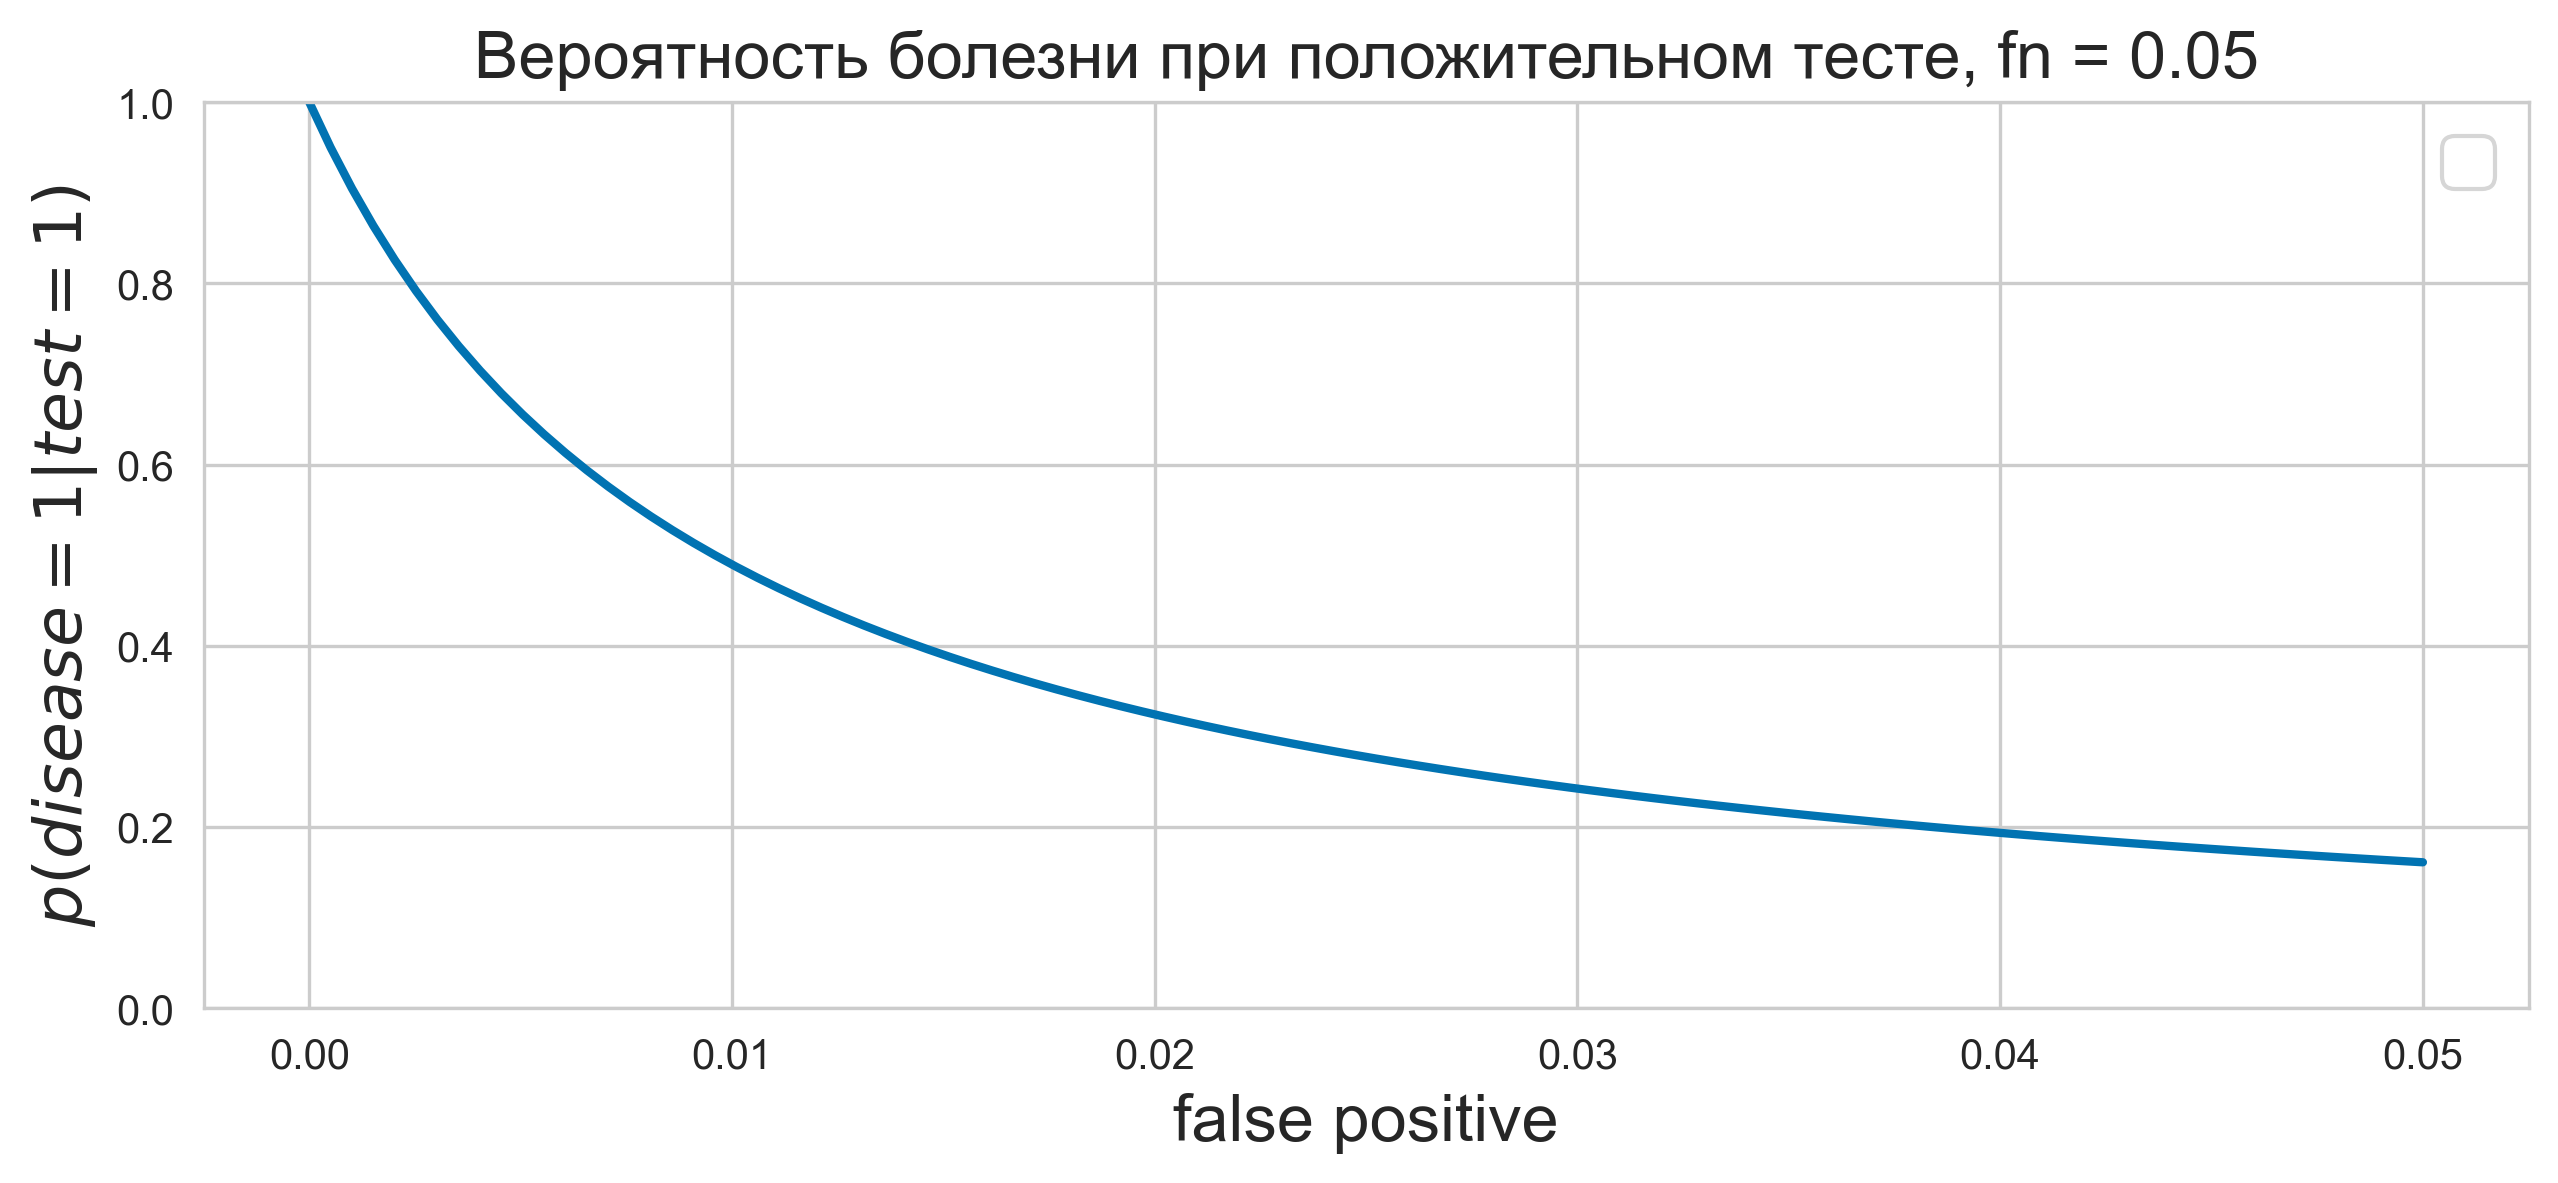

In [6]:
# Вероятность болезни при положительном тесте, fn = 0.05
draw_plot(fp_space, 
          compute_posterior(test=1, fp=fp_space),
          title='Вероятность болезни при положительном тесте, fn = 0.05',
          xlabel='false positive',
          ylabel='$p(disease=1|test=1)$')

No handles with labels found to put in legend.


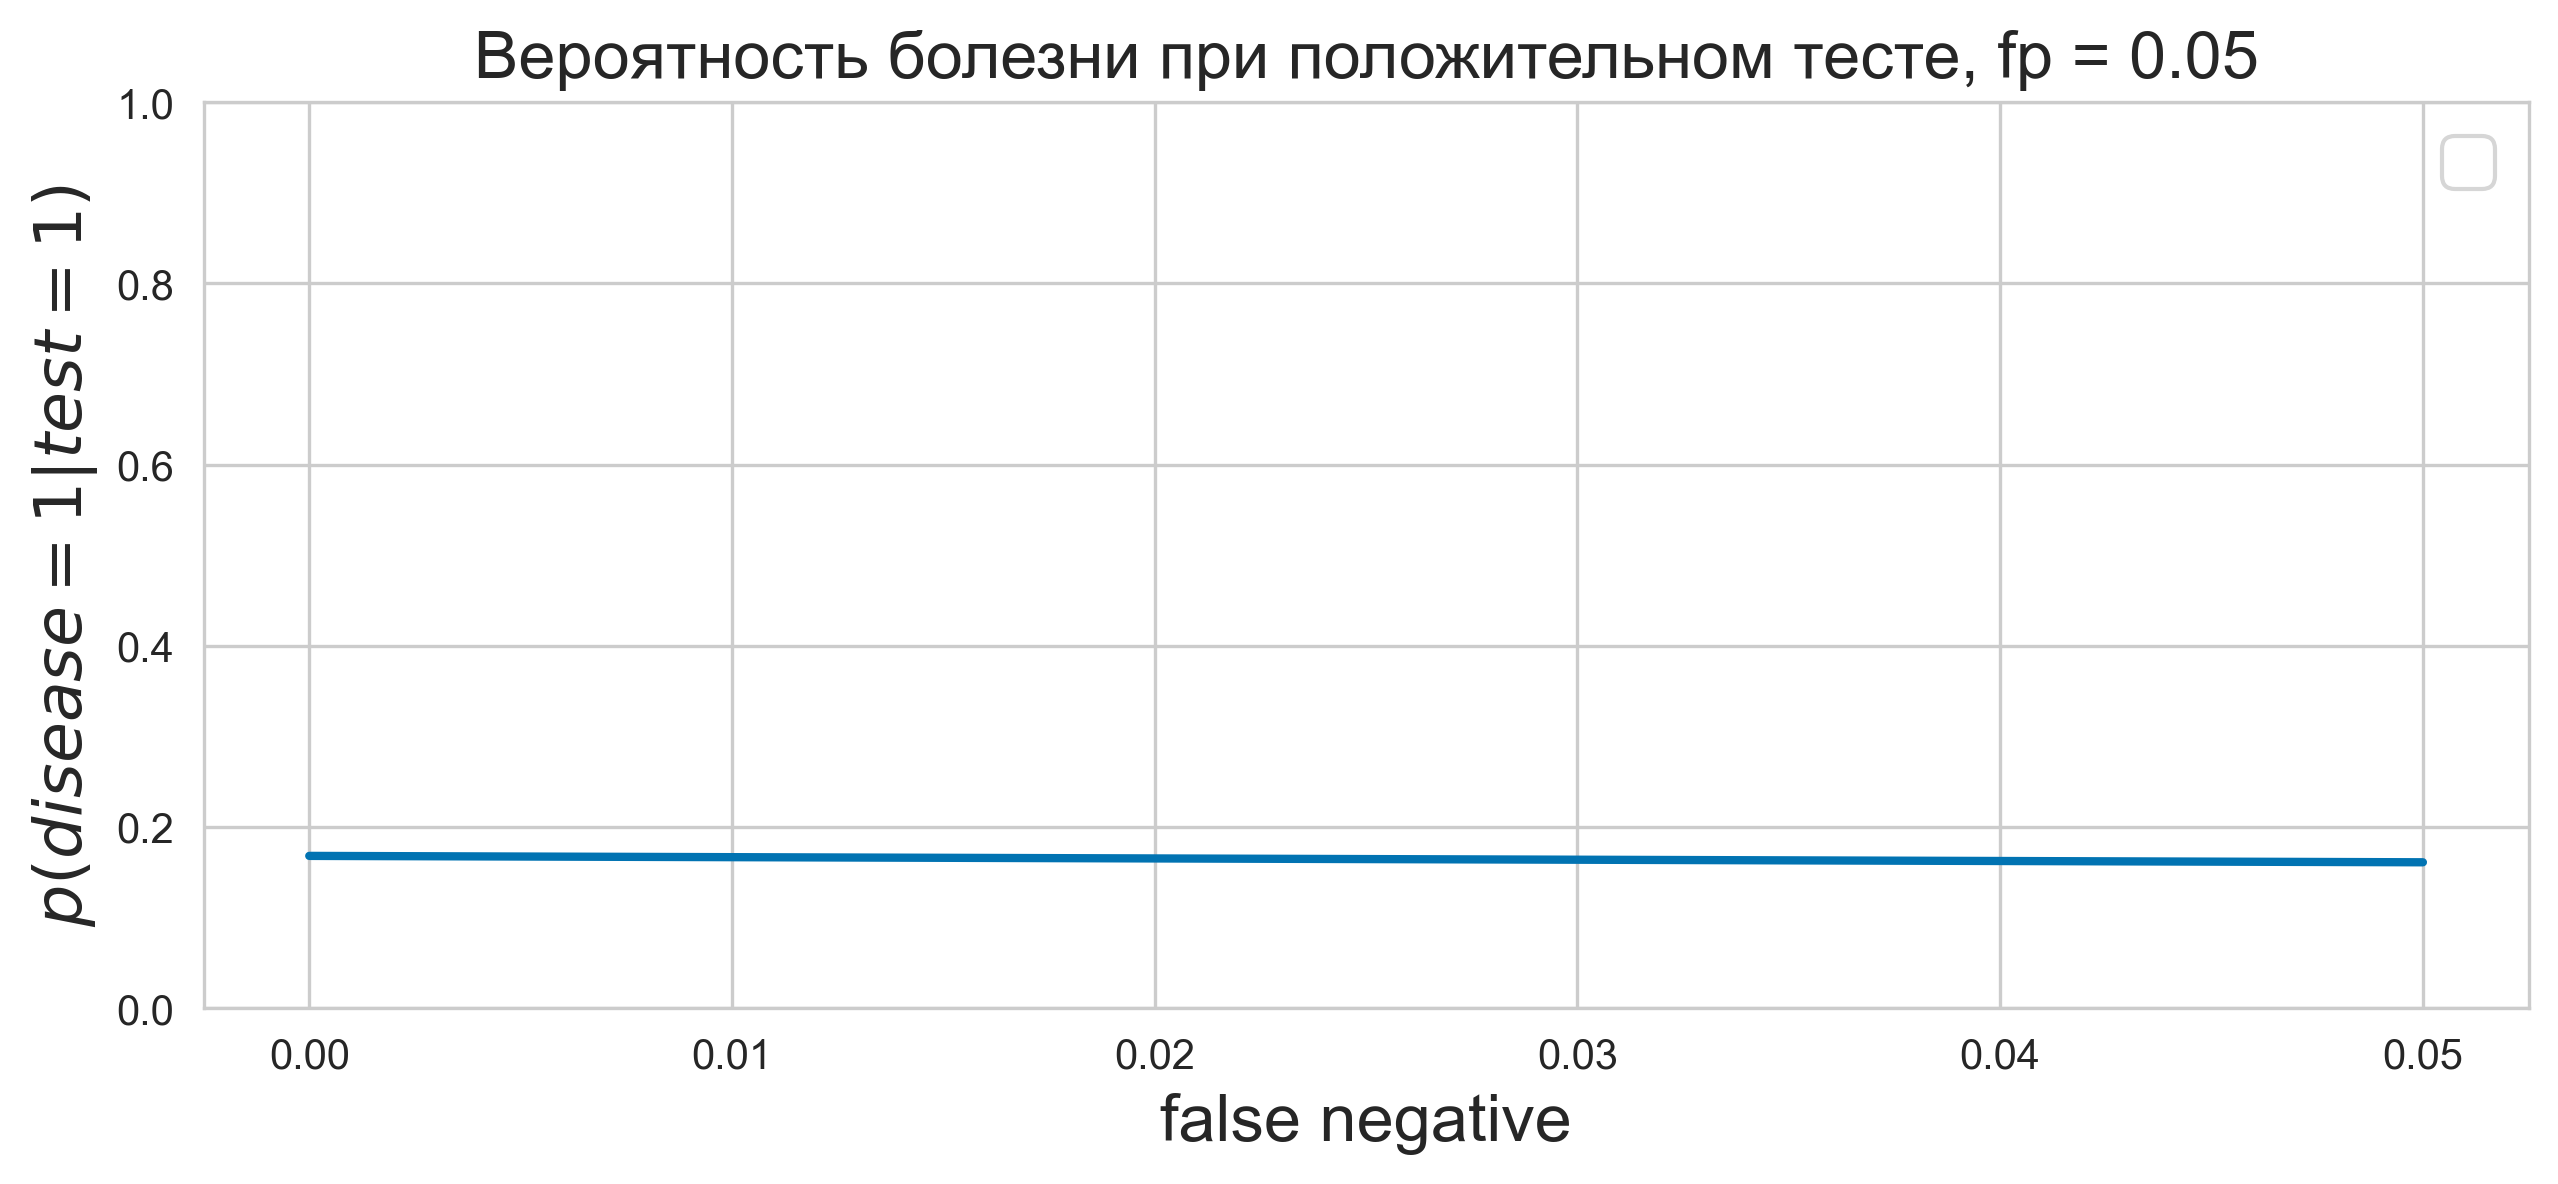

In [7]:
# Вероятность болезни при положительном тесте, fp = 0.05
draw_plot(fn_space, 
          compute_posterior(test=1, fn=fn_space),
          title='Вероятность болезни при положительном тесте, fp = 0.05',
          xlabel='false negative',
          ylabel='$p(disease=1|test=1)$')

No handles with labels found to put in legend.


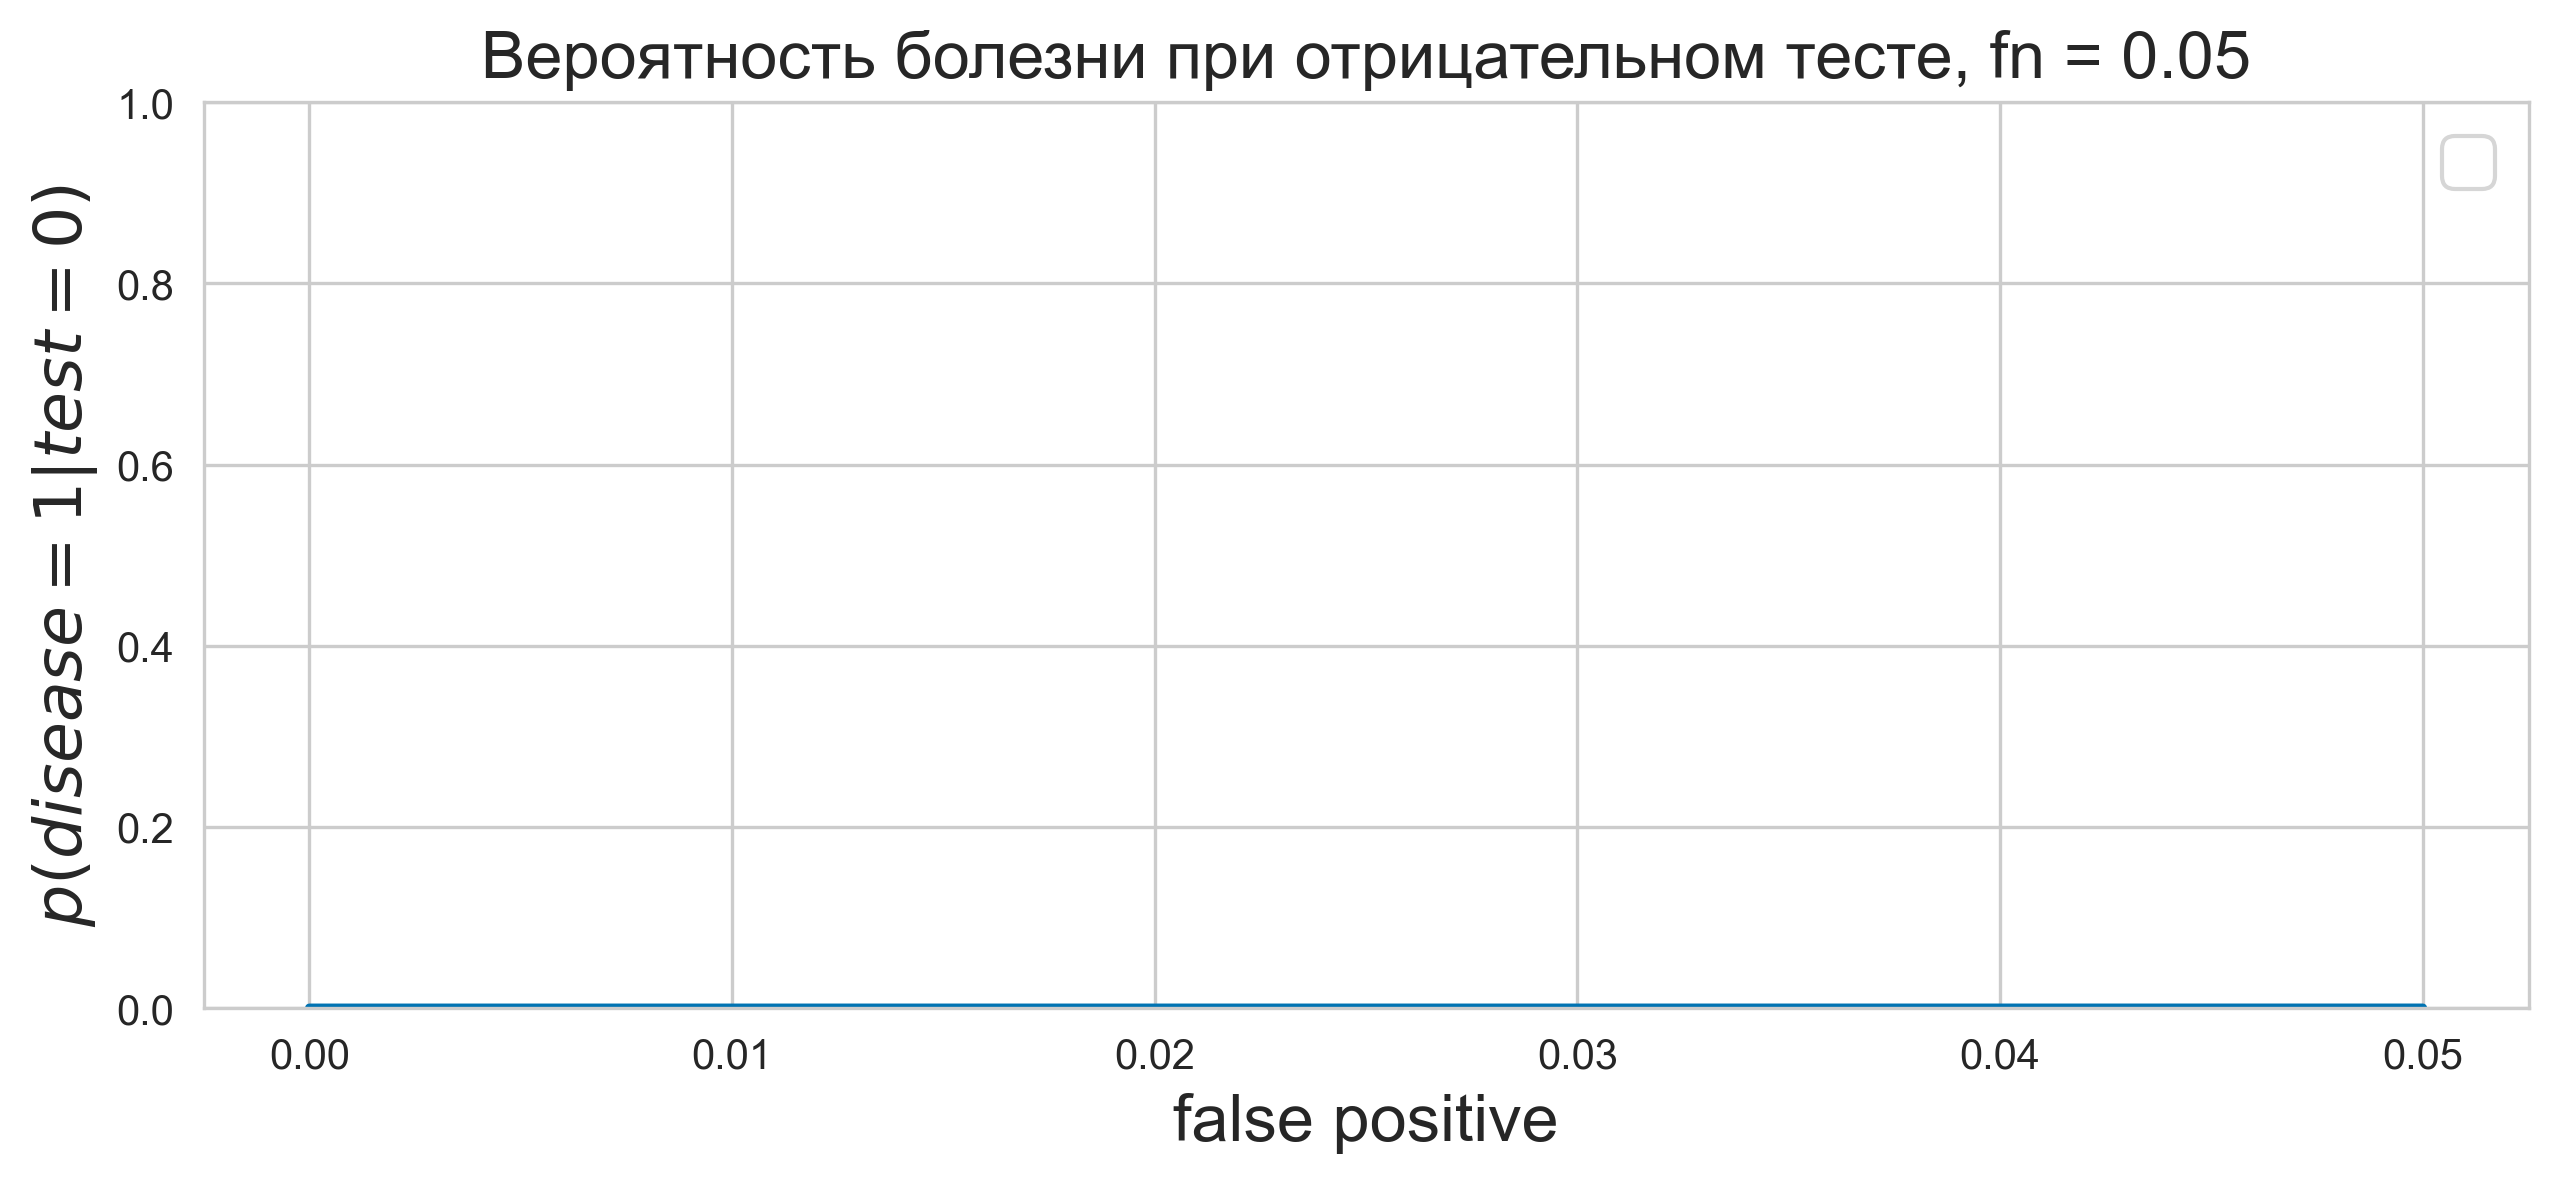

In [8]:
# Вероятность болезни при отрицательном тесте, fn = 0.05
draw_plot(fp_space, 
          compute_posterior(test=0, fp=fp_space),
          title='Вероятность болезни при отрицательном тесте, fn = 0.05',
          xlabel='false positive',
          ylabel='$p(disease=1|test=0)$')

No handles with labels found to put in legend.


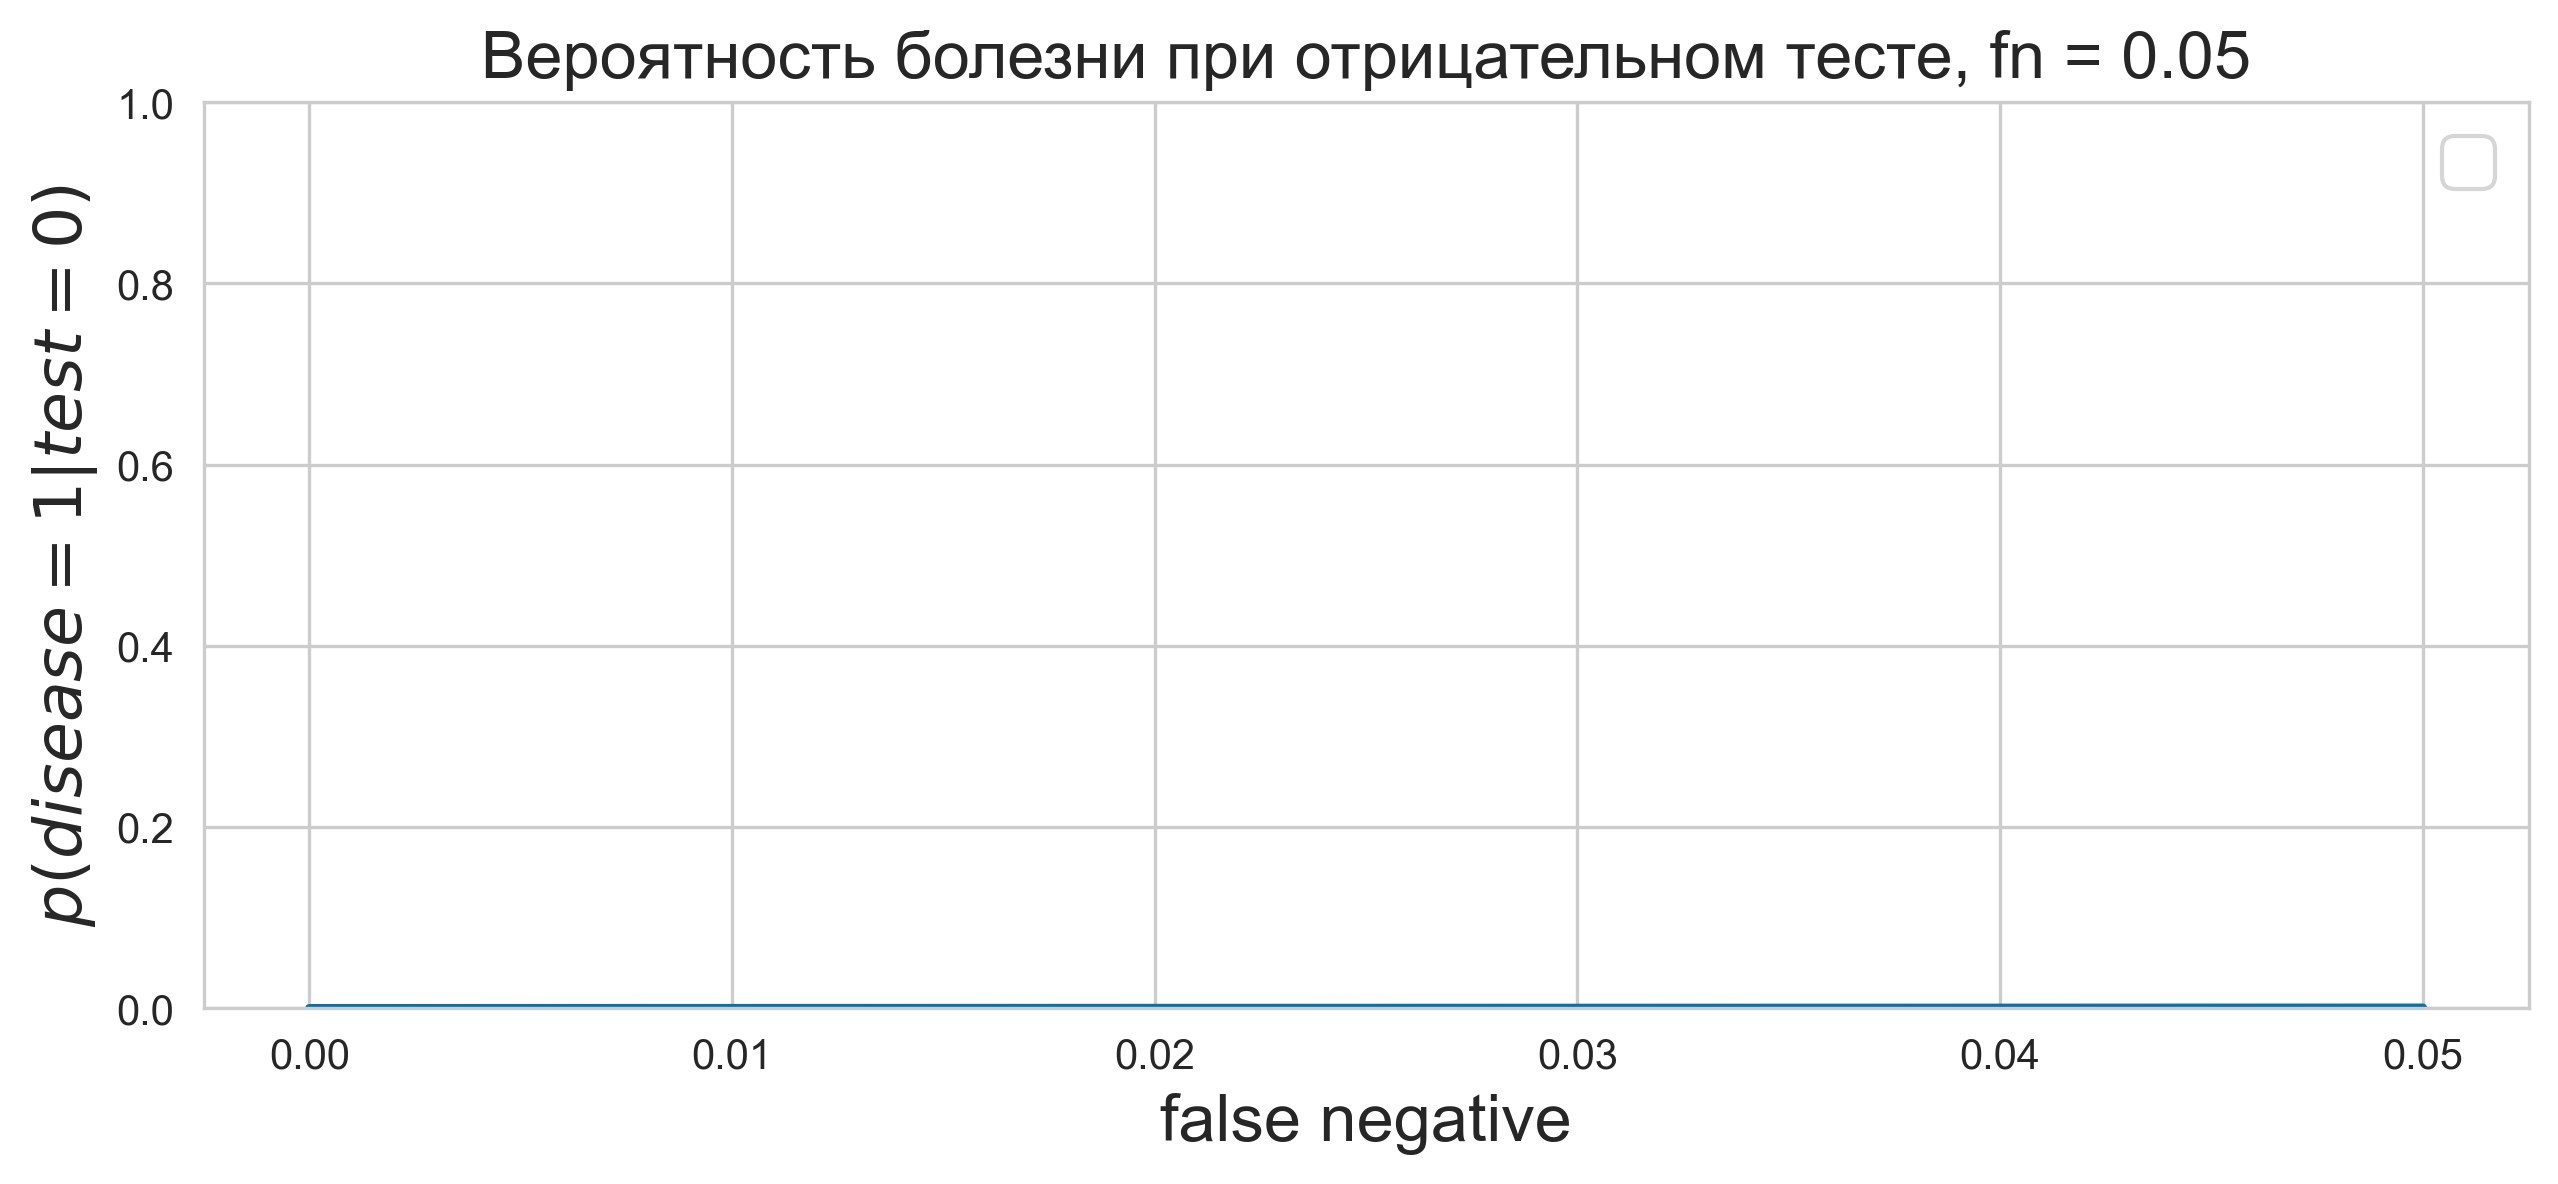

In [9]:
# Вероятность болезни при отрицательном тесте, fp = 0.05
draw_plot(fn_space, 
          compute_posterior(test=0, fn=fn_space),
          title='Вероятность болезни при отрицательном тесте, fn = 0.05',
          xlabel='false negative',
          ylabel='$p(disease=1|test=0)$')

#### Судя по графикам снижение false positive ошибок повышает точность теста. Если сравнить первый график со всеми остальными видно, что изменение false positive в меньшую сторону повышает вероятность болезни при положительном тесте.

### Часть II: О линейной регрессии

In [10]:
data = pd.read_csv('owid-covid-data.csv')

In [11]:
data.replace(0, 1, inplace=True)

In [12]:
russia = data[(data.location == 'Russia') & (data.date >= '2020-03-03')].set_index('date')[['total_cases', 'new_cases']]

In [13]:
russia.head()

,total_cases,new_cases
date,,
2020-03-03,3.0,1.0
2020-03-04,3.0,1.0
2020-03-05,4.0,1.0
2020-03-06,13.0,9.0
2020-03-07,13.0,1.0


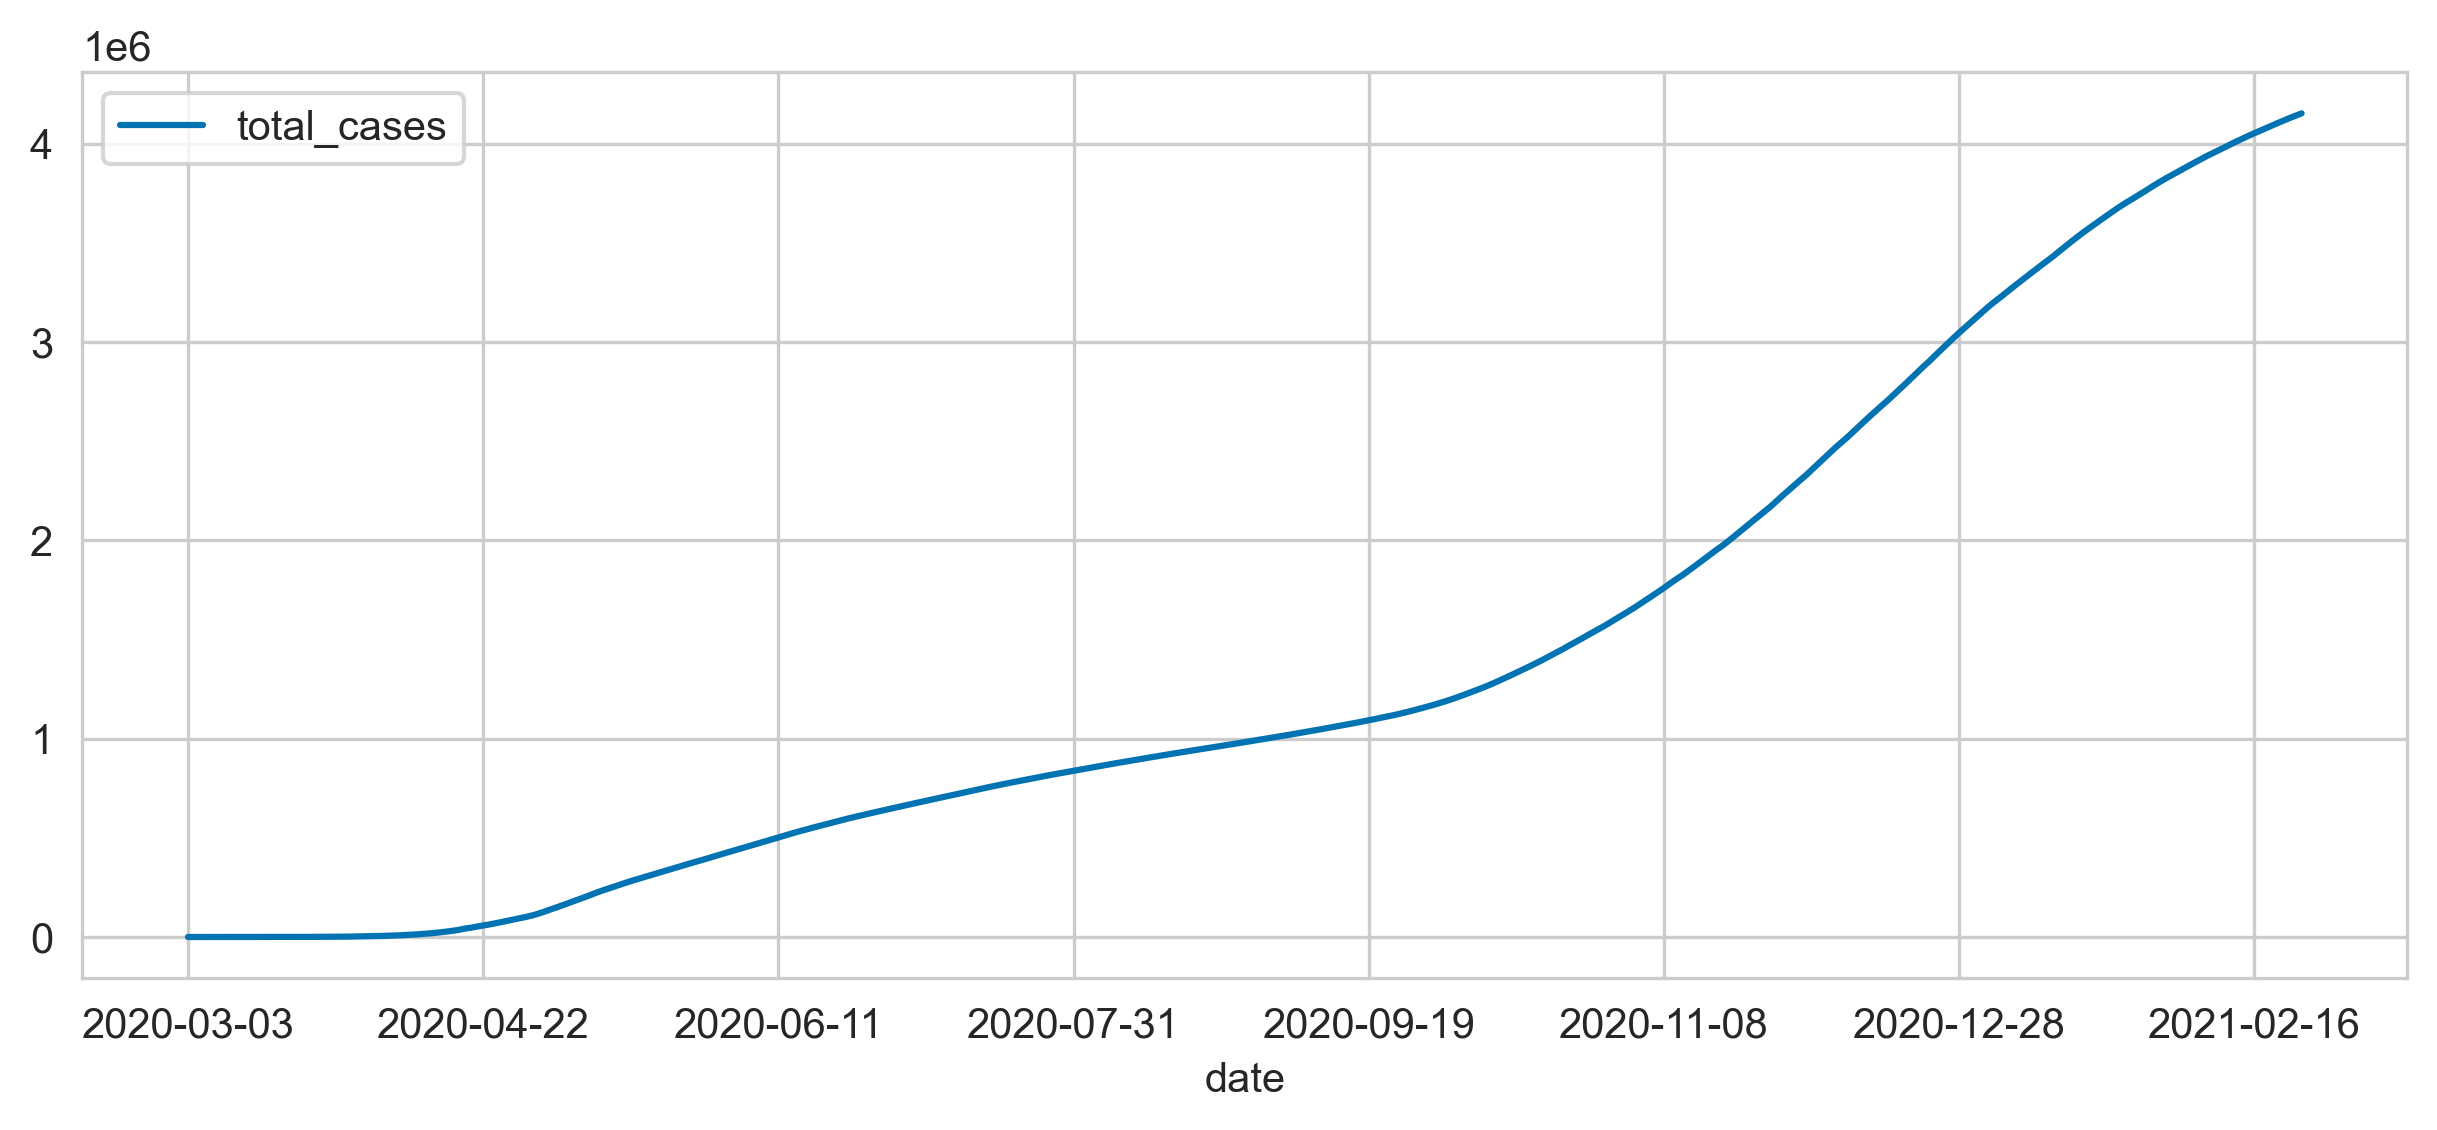

In [14]:
# total cases
russia[['total_cases']].plot.line(figsize = (10,4));

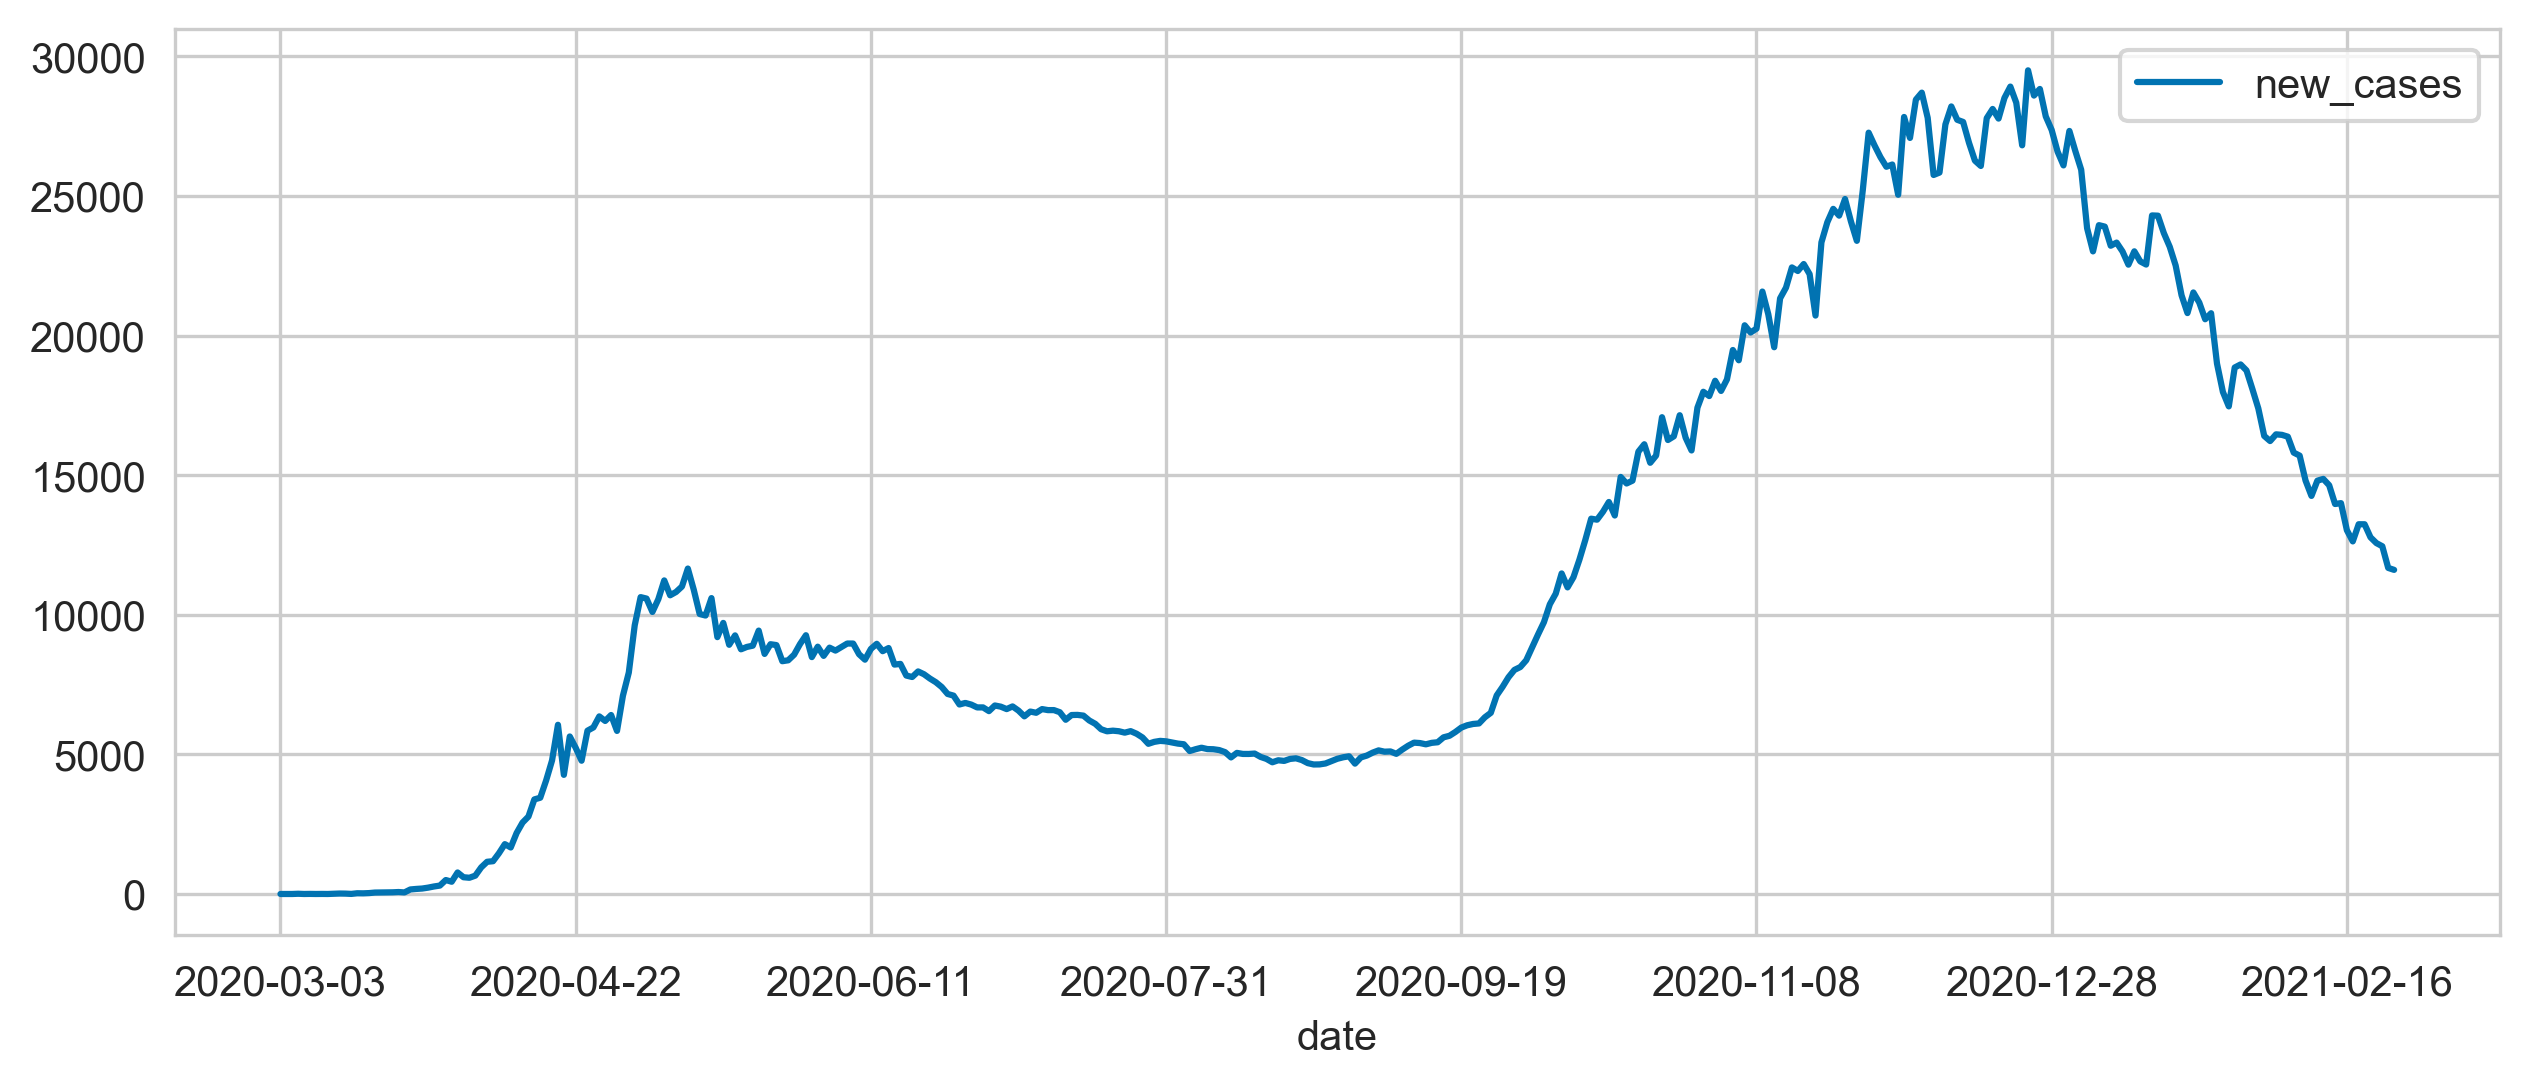

In [15]:
# new cases
russia[['new_cases']].plot.line(figsize = (10,4));

#### y ~ exp(линейная функция от x)

In [16]:
linear = linear_model.LinearRegression(fit_intercept=True)

In [17]:
x = np.array(range(1, len(russia['total_cases']) + 1)).reshape(-1, 1)
y = np.log(russia['total_cases'].values)

In [18]:
linear.fit(x, y)

LinearRegression()

In [19]:
predicted = np.exp(linear.predict(x.reshape(-1, 1)))

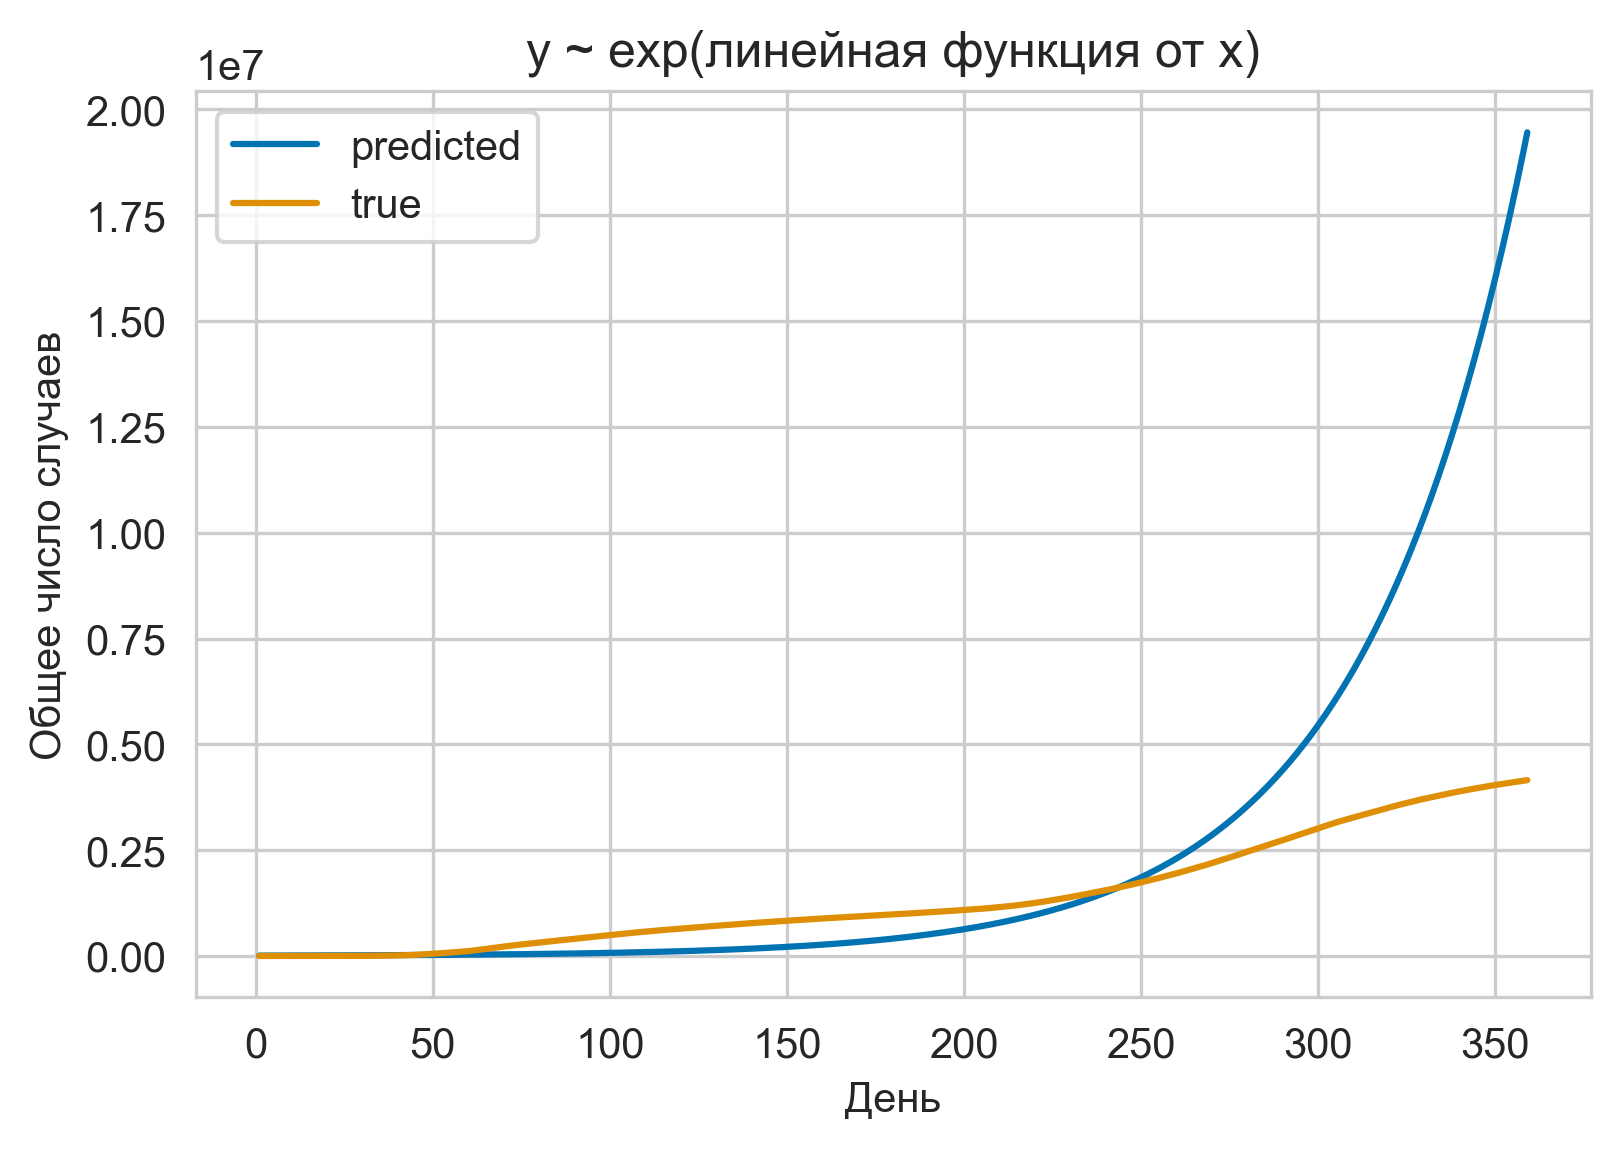

In [20]:
plt.plot(x, predicted, label="predicted")
plt.plot(x, np.exp(y), label="true")
plt.legend()
plt.title('y ~ exp(линейная функция от x)')
plt.xlabel('День')
plt.ylabel('Общее число случаев');

#### апостериорное распределение параметров этой модели для достаточно широкого априорного распределения

In [21]:
init_mu = np.array([0, 0])
init_sigma = 30 * np.array([[1, 0], [0, 1]])

def get_posterior(x, y):
    x = np.hstack((np.ones((len(x), 1)), x))

    W = np.linalg.inv(x.T @ x) @ x.T @ y
    y_pred = x @ W
    noise_var = (y - y_pred).var()
    alpha = 1 / noise_var

    sigma = np.linalg.inv(np.linalg.inv(init_sigma) + alpha * x.T @ x)
    mu = sigma @ (np.linalg.inv(init_sigma) @ init_mu + alpha * x.T @ y)
    
    return mu, sigma

In [22]:
mu, sigma = get_posterior(x, y)

In [23]:
mu

array([9.03837497, 0.02159032])

In [24]:
linear.intercept_, linear.coef_

(9.049346867895732, array([0.02154454]))

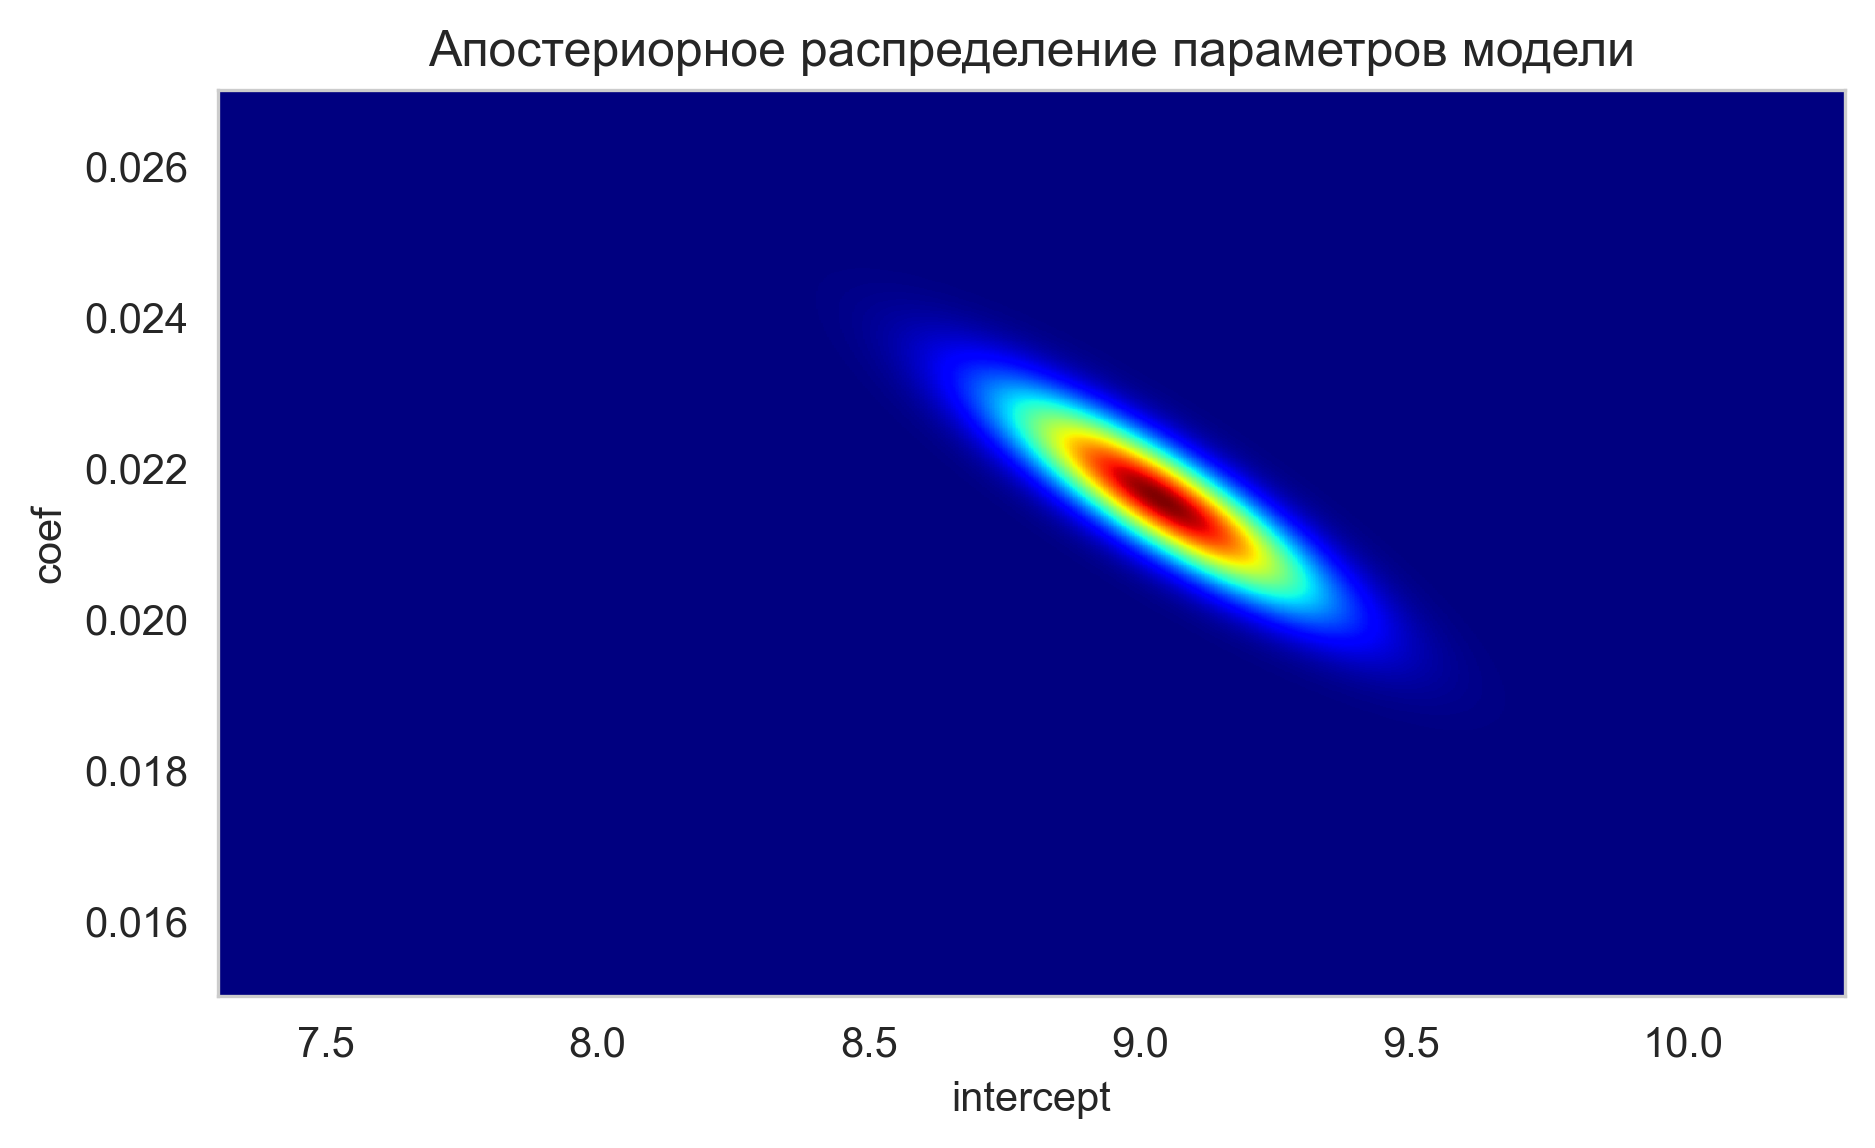

In [25]:
N = 1000

plot_lims = (
    (7.3, 10.3), # intercept
    (0.015, 0.027) # coef
)

X = np.linspace(*plot_lims[0], N)
Y = np.linspace(*plot_lims[1], N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

plt.figure(figsize=(7, 4))
plt.xlim(plot_lims[0])
plt.ylim(plot_lims[1])
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet, shading='auto')
plt.title('Апостериорное распределение параметров модели')
plt.xlabel('intercept')
plt.ylabel('coef')
plt.show()